In [20]:
import numpy as np
import os
import os.path as osp
import matplotlib.pyplot as plt
import time
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from joblib import Parallel, delayed

In [21]:
sns.set(font_scale=1.6)

In [22]:
# Random seeds for reproducibility
np.random.seed(123)
start_time = time.time()

#### Function to sample sojourn time and output departure time

In [23]:
def statefunction(stateI, tI, t_max):
    ##define transition rate prameters
    gamma = 2.8e-5
    lamda = 7.26e-5
    
    ####given state0
    if stateI == 0:        
        #use inverse transform sampling
        U = np.random.uniform(0, 1, 1)
        tO = tI - np.log(1-U)/(2*gamma+lamda)
        
    ####given state1
    if stateI == 1:
        #use inverse transform sampling
        U = np.random.uniform(0, 1, 1)
        tO = tI-np.log(1-U)/(gamma+lamda)
        
    ####given state2
    if stateI == 2:
        #print('stateI == 2, END')
        tO = t_max
        
    return float(tO) #output departure time

#### Function to define the state transition 

In [24]:
def tranfunction(stateI, tO):
    stateI = int(stateI)
    tO = float(tO)
    
    #define transition rate prameters
    gamma = 2.8e-5
    lamda = 7.26e-5
    
    #specify transition rates across state
    phi01 = 2*gamma
    phi02 = lamda
    phi12 = gamma+lamda

    #following departure
    #calculate transition probability
    ####given state0
    if stateI == 0:
        #probability
        tranAll = phi01+phi02
        tranP = [phi01/tranAll, phi02/tranAll]
        tranS = [1, 2]
        tranResult = np.matrix([tranS, tranP]).transpose()
       
    ####given state1
    if stateI == 1:
        #probability
        tranAll = phi12
        tranP = 1
        tranS = 2
        tranResult = np.matrix([tranS, tranP])
        
    ####given state2
    if stateI == 2:
        print('NULL Transition out from State-2')
    
    ####generate a random number from uniform [0,1]
    u = np.random.uniform(0, 1, 1)
    #sum the transition probability
    sumTransP = np.cumsum(tranResult[:,1])
    #determine the index of state out
    idx = np.sum((u>=sumTransP) + 0) + 1 #+0 convert boolean to numeric
    
    #result
    stateOut = tranResult[idx-1, 0]
    final_ret = [stateOut]
    
    return final_ret

#### Run Monte Carlo

In [25]:
#number of replications
N_max = int(1e6)
#time horizon
t_max = 8e4 + 1

## Initialize storage
all_list = np.empty((0,2), int)

## Initialize no. of replication

sample_trace = []
for n_rep in tqdm(range(1, N_max+1)):
    
    #print(n_rep/N_max)
    
    #initialize time
    t_in_A = [0.]
    #initialize state
    state_in_A = [0]
  
    while (t_in_A[-1] < t_max):
        t_in = t_in_A[-1]
        state_in = state_in_A[-1]
        t_out = statefunction(state_in, t_in, t_max)
        
        if state_in==2:
            #print('state_in==2')
            t_in_A = np.append(t_in_A, t_max)
            state_in_A = np.append(state_in_A, 2)
            
        else:
            state_out = tranfunction(state_in, t_out)
            #update
            t_in_A = np.append(t_in_A, t_out)
            state_in_A = np.append(state_in_A, state_out[0])
    
        sample_trace.append([n_rep, state_in, t_in, t_out])

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:49<00:00, 9155.62it/s]


#### Data analytics to derive state probability

In [26]:
df = pd.DataFrame(sample_trace, columns=['sample_id', 'state', 't_in', 't_out'])

In [27]:
df.head()

,sample_id,state,t_in,t_out
0,1,0.0,0.000000,9271.167523
1,1,1.0,9271.167523,11828.663349
2,1,2.0,11828.663349,80001.000000
3,2,0.0,0.000000,9883.910851
4,2,1.0,9883.910851,49158.086486


In [28]:
time_idx = np.arange(16, t_max+1, 16)
time_idx

array([1.6000e+01, 3.2000e+01, 4.8000e+01, ..., 7.9968e+04, 7.9984e+04,
       8.0000e+04])

In [29]:
# def get_state_probability(df, t, N_max):
#     res = df[(df['t_in'] <= t) & (df['t_out'] > t)].groupby('state')['sample_id'].count().values
    
#     return [res[0]/N_max, res[1]/N_max, res[2]/N_max]

#state_prob = Parallel(n_jobs=-1)(delayed(get_state_probability)(df, time_idx[i], N_max) for i in tqdm(range(len(time_idx))))

In [ ]:
state_prob = []

for t in time_idx:
    res = df[(df['t_in'] <= t) & (df['t_out'] > t)].groupby('state')['sample_id'].count().values
    
    state_prob.append([t, res[0]/N_max, res[1]/N_max, res[2]/N_max])

In [31]:
state_prob = np.array(state_prob)

df_res = pd.DataFrame()
df_res['time'] = time_idx
df_res['state_0'] = state_prob[:, 0]
df_res['state_1'] = state_prob[:, 1]
df_res['state_2'] = state_prob[:, 2]

In [32]:
df_res.head()

,time,state_0,state_1,state_2
0,16.0,0.997984,0.000895,0.001121
1,32.0,0.995997,0.001729,0.002274
2,48.0,0.993874,0.002629,0.003497
3,64.0,0.991758,0.003541,0.004701
4,80.0,0.989762,0.004375,0.005863


In [33]:
df_res.to_csv("MCS_homo_80000.csv", index = False)

In [34]:
#####################################################################
## used time
#####################################################################
end_time = time.time()
used_time = end_time - start_time
print("--- %s seconds ---" % (used_time))

--- 229.16662645339966 seconds ---


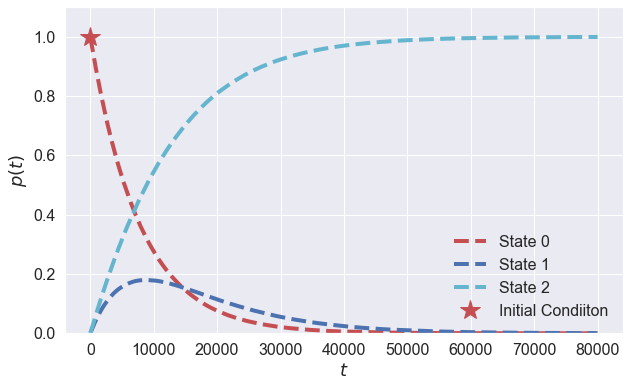

In [35]:
######################################################
## Plotting
######################################################
plt.figure(figsize=(10, 6))
plt.plot(time_idx, state_prob[:,0], 'r--', linewidth = 4, label = "State 0")
plt.plot(time_idx, state_prob[:,1], 'b--', linewidth = 4, label = "State 1")
plt.plot(time_idx, state_prob[:,2], 'c--', linewidth = 4, label = "State 2", markersize=20)
plt.plot(0, 1, 'r*', linewidth = 4, label = "Initial Condiiton", markersize=20)
plt.legend(frameon=False,fontsize=16)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('$p(t)$', fontsize=18)
# plt.xlim([-1,30])
plt.ylim([0,1.1])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

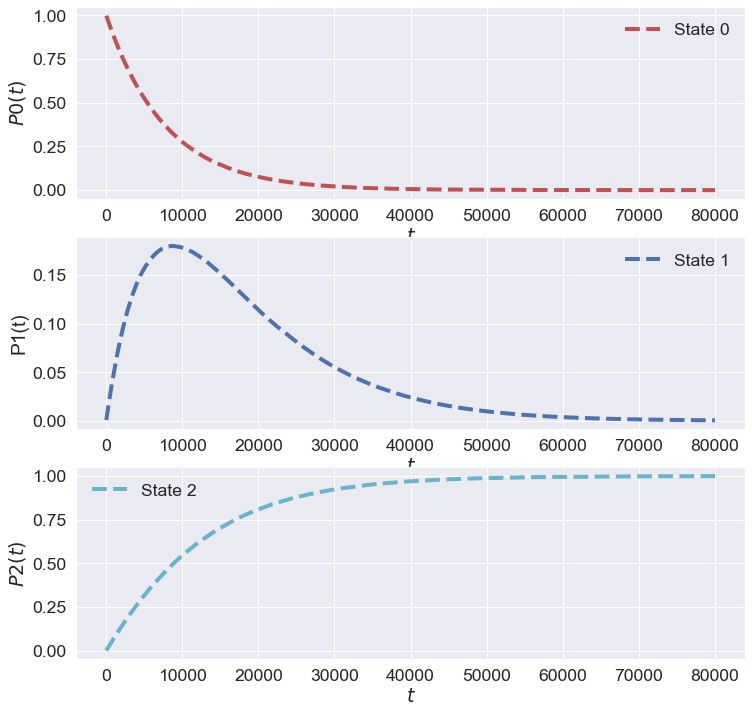

In [36]:
######################################################
## subplot
######################################################
ax = plt.figure(1,figsize=(12, 12))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(3, 1, 1)
plt.plot(time_idx, state_prob[:,0:1], 'r--', linewidth = 4, label = "State 0")
plt.legend(frameon=False)
plt.xlabel('$t$')
plt.ylabel('$P0(t)$')

plt.subplot(3, 1, 2)
plt.plot(time_idx, state_prob[:,1:2], 'b--', linewidth = 4, label = "State 1")
plt.legend(frameon=False)
plt.xlabel('$t$')
plt.ylabel('P1(t)')

plt.subplot(3, 1, 3)
plt.plot(time_idx, state_prob[:,2:3], 'c--', linewidth = 4, label = "State 2")
plt.legend(frameon=False)
plt.xlabel('$t$')
plt.ylabel('$P2(t)$')

plt.show()